In [22]:
# mount colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
pip install memory_profiler

In [24]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB  # or any other classifier
from sklearn.metrics import classification_report, accuracy_score
%load_ext memory_profiler
import time
import matplotlib.pyplot as plt



The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [25]:
%%time
%%memit

#df_news=pd.read_parquet('/content/drive/My Drive/Colab Notebooks/fake_news/trials_marco/news_cleaned_truncated_100_each.parquet.gzip')
#df_news_dedup=df_news.drop_duplicates(keep=False)
#print(df_news_dedup.duplicated(keep=False).value_counts())

df_news=pd.read_parquet('/content/drive/My Drive/Colab Notebooks/fake_news/trials_tobi/news_cleaned_truncated_small_68k_samples_no_tokenization.parquet.gzip')
print(df_news['type'].value_counts())

reliable      18655
political     12673
bias           8578
fake           7985
conspiracy     6489
rumor          4550
unknown        2961
clickbait      2276
unreliable     1202
junksci         974
satire          932
hate            744
Name: type, dtype: int64
peak memory: 8389.53 MiB, increment: 92.04 MiB
CPU times: user 320 ms, sys: 405 ms, total: 725 ms
Wall time: 1.08 s


In [26]:
# Model with sparsity

# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(df_news['content'], df_news['type'], test_size=0.2, stratify=df_news['type'])

# TF-IDF Vectorisation
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train the model
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# evaluate the model
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, zero_division=1))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

        bias       0.76      0.14      0.23      1716
   clickbait       1.00      0.00      0.00       455
  conspiracy       0.97      0.10      0.18      1298
        fake       0.97      0.25      0.40      1597
        hate       1.00      0.00      0.00       149
     junksci       1.00      0.00      0.00       195
   political       0.40      0.48      0.44      2535
    reliable       0.38      0.96      0.55      3731
       rumor       0.97      0.16      0.27       910
      satire       1.00      0.00      0.00       186
     unknown       1.00      0.02      0.04       592
  unreliable       1.00      0.24      0.39       240

    accuracy                           0.43     13604
   macro avg       0.87      0.20      0.21     13604
weighted avg       0.68      0.43      0.35     13604

Accuracy: 0.4261981770067627


In [27]:
# resample to handle imbalanced dataset
#Oversampling: The most common method is Synthetic Minority Over-sampling Technique (SMOTE).
#SMOTE creates synthetic samples for minority classes, making them more represented in the dataset.
#This can help the model learn better about these classes.

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Create a pipeline
clf = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    SMOTE(random_state=42),
    MultinomialNB()
)

# Fit the model
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))


              precision    recall  f1-score   support

        bias       0.73      0.29      0.42      1716
   clickbait       0.24      0.36      0.28       455
  conspiracy       0.52      0.43      0.47      1298
        fake       0.65      0.55      0.60      1597
        hate       0.10      0.40      0.16       149
     junksci       0.20      0.63      0.30       195
   political       0.48      0.56      0.52      2535
    reliable       0.79      0.64      0.71      3731
       rumor       0.67      0.78      0.73       910
      satire       0.12      0.22      0.15       186
     unknown       0.23      0.41      0.30       592
  unreliable       0.60      0.33      0.42       240

    accuracy                           0.53     13604
   macro avg       0.44      0.47      0.42     13604
weighted avg       0.60      0.53      0.54     13604



In [28]:
# using different model that supports class weights
#adjusting class weights alters the learning algorithm.
#It assigns more importance to the minority classes during the training process.

from sklearn.linear_model import LogisticRegression

# TF-IDF Vectorisation
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train the model with class weights
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, zero_division=1))


              precision    recall  f1-score   support

        bias       0.53      0.51      0.52      1716
   clickbait       0.26      0.40      0.31       455
  conspiracy       0.47      0.50      0.49      1298
        fake       0.78      0.72      0.75      1597
        hate       0.15      0.34      0.20       149
     junksci       0.34      0.70      0.46       195
   political       0.58      0.47      0.52      2535
    reliable       0.81      0.72      0.76      3731
       rumor       0.70      0.82      0.76       910
      satire       0.14      0.24      0.17       186
     unknown       0.33      0.39      0.36       592
  unreliable       0.45      0.45      0.45       240

    accuracy                           0.59     13604
   macro avg       0.46      0.52      0.48     13604
weighted avg       0.62      0.59      0.60     13604



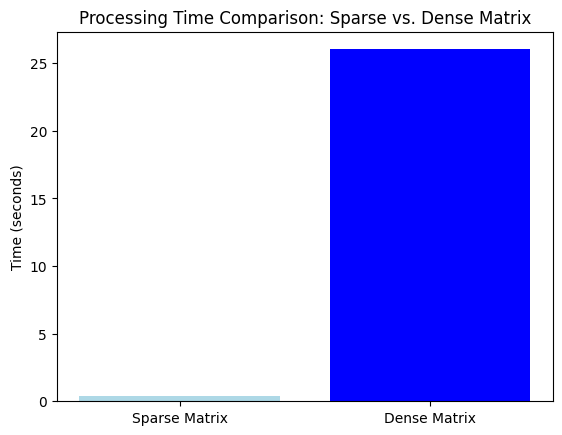

In [29]:
# show difference of sparcity in processing (sparse vs dense matrix)

# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(df_news['content'], df_news['type'], test_size=0.2, stratify=df_news['type'])

# TF-IDF Vectorization - Sparse Format
vectorizer_sparse = TfidfVectorizer(stop_words='english')
X_train_tfidf_sparse = vectorizer_sparse.fit_transform(X_train)
X_test_tfidf_sparse = vectorizer_sparse.transform(X_test)

# Convert Sparse to Dense Format
X_train_tfidf_dense = X_train_tfidf_sparse.toarray()
X_test_tfidf_dense = X_test_tfidf_sparse.toarray()

# Initialize the classifier
clf = MultinomialNB()

# Time tracking for Sparse Matrix
start_time_sparse = time.time()
clf.fit(X_train_tfidf_sparse, y_train)
clf.predict(X_test_tfidf_sparse)
end_time_sparse = time.time()
time_sparse = end_time_sparse - start_time_sparse

# Time tracking for Dense Matrix
start_time_dense = time.time()
clf.fit(X_train_tfidf_dense, y_train)
clf.predict(X_test_tfidf_dense)
end_time_dense = time.time()
time_dense = end_time_dense - start_time_dense

# Plotting the comparison
plt.bar(['Sparse Matrix', 'Dense Matrix'], [time_sparse, time_dense], color=['lightblue', 'blue'])
plt.ylabel('Time (seconds)')
plt.title('Processing Time Comparison: Sparse vs. Dense Matrix')
plt.show()

